# Born to slide: mobile origin licensing factors confer resistance to transcription conflicts

<img style="float: left;" src="https://icons.iconarchive.com/icons/dan-wiersma/solar-system/48/Mars-icon.png">

## Jupyter notebooks 

#### Figures:
+ S6B

#### Archives:
+ Transcription_naked-DNA_T7T_ATP.yama
+ Transcription_ORC-DNA_T7T_ATP.yama

#### Additional data:
+ none

### Initialize ImageJ

In [1]:
import imagej
ij = imagej.init('/Applications/Fiji.app')
ij.getVersion()

'2.1.0/1.53c'

### Imports

In [2]:
import sys
sys.path.insert(0, '..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import awesome_data
from marspy.convert.archive import DnaMoleculeArchive, instantiate_archive, describe_archives
from tqdm.notebook import tqdm
from functools import reduce

marspy initialized.


### Select archives

In [3]:
selected_archives = ['Transcription_naked-DNA_T7T_ATP.yama',
                     'Transcription_ORC-DNA_T7T_ATP.yama']

### Figure style and output directory

In [4]:
from figure_style import *

In [5]:
set_style_paper()

In [6]:
dir_out = '/Volumes/pool-duderstadt/Matthias/Manuscript/Figures/SVGs/Figure6/'
dir_out

'/Volumes/pool-duderstadt/Matthias/Manuscript/Figures/SVGs/Figure6/'

### Instantiate selected archives

In [7]:
for archive in tqdm(selected_archives):
    instantiate_archive(archive, awesome_data.datasets)

cdc6 not found. Setting default to n/a



### Archives Overview

In [8]:
describe_archives(DnaMoleculeArchive.instances)

,# of datasets,# of molecules,labeled proteins,nucleotide,HS challenge?,chromatin,terminator?,archive validation
Transcription_naked-DNA_T7T_ATP,1,325,ybbR-LD655-T7,ATP,False,n/a,True,passed
Transcription_ORC-DNA_T7T_ATP,3,612,SORT-LD555-ORC; ybbR-LD655-T7,ATP,False,n/a,True,passed


### Load segment tables, apply filter & detect pauses

In [9]:
for index,archive in enumerate(tqdm(DnaMoleculeArchive.instances)):
    
    archive.add_segments_tables()
    archive.filter_segments(b_min=-10, sigma_b_max=10)
    archive.detect_pauses()


### Generate main df

In [10]:
def setup_pandas_df(archive_instances):
    '''
    Sets up a multilevel df with all relevant information
    '''
    
    # indices will be UIDs
    prefixes = set()
    for archive in archive_instances:
        prefixes.update(archive.prefixes)
    col_1 = sorted(list(prefixes))
    #inside
    col_2 = ['initial_intensity', 'lifetime', 'start_site', 'stop_site', 'number_pauses']
    col_3 = ['']
    hier_index = pd.MultiIndex.from_product([col_1,col_2,col_3],names=['molecule','properties','properties_details'])

    return pd.DataFrame(columns=hier_index)
    

In [11]:
df = setup_pandas_df(DnaMoleculeArchive.instances)

# sort MultiIndexCols for performance
df.sort_index(axis=1, inplace=True)
df.head()


Empty DataFrame
Columns: [(ORC_1_, initial_intensity, ), (ORC_1_, lifetime, ), (ORC_1_, number_pauses, ), (ORC_1_, start_site, ), (ORC_1_, stop_site, ), (ORC_2_, initial_intensity, ), (ORC_2_, lifetime, ), (ORC_2_, number_pauses, ), (ORC_2_, start_site, ), (ORC_2_, stop_site, ), (T7_1_, initial_intensity, ), (T7_1_, lifetime, ), (T7_1_, number_pauses, ), (T7_1_, start_site, ), (T7_1_, stop_site, )]
Index: []

In [12]:
# fill dataframe
for archive in tqdm(DnaMoleculeArchive.instances):

    for molecule in archive.molecules:
        #print('handling molecule '+molecule.uid)
        # general columns first
        df.loc[molecule.uid,'dna_length'] = molecule.calc_length_dna()
        df.loc[molecule.uid,'dna_count_valid'] = archive.dna_count_valid
        df.loc[molecule.uid,'hs_wash'] = archive.highsalt_wash
        df.loc[molecule.uid,'nucleotide'] = archive.nucleotide
        df.loc[molecule.uid,'t7_terminator'] = archive.t7_terminator
        df.loc[molecule.uid,'tags'] = reduce(lambda tag1,tag2: tag1+','+tag2, molecule.tags)

        # general proteins
        for protein in molecule.proteins:
            #store protein number
            df.loc[molecule.uid,'number_'+protein] = molecule.params['Number_'+protein]
            #assign label for each protein
            df.loc[molecule.uid,'label_'+protein] = archive.labels[protein]
            
            # burst velocity (weighted average, exclude pauses, all regions)
            # always calculate weighted average for all seg_dfs of a protein
            # check if protein has a SegmentsTable, otherwise skip
            if len(list(filter(lambda seg_df: protein in seg_df.prefix, molecule.seg_dfs))) > 0:
                df.loc[molecule.uid,('velocity_'+protein)] = \
                np.average([seg_df.calc_rate()[0] for seg_df in list(filter(lambda seg_df: protein in seg_df.prefix, molecule.seg_dfs))],
                           weights=[seg_df.calc_rate()[1] for seg_df in list(filter(lambda seg_df: protein in seg_df.prefix, molecule.seg_dfs))])
        
        # every specific protein
        for prefix in molecule.prefixes:

            #take mean intensity from first 5 frames (maybe need try block later if shorter traces)
            df.loc[molecule.uid,(prefix,'initial_intensity')] = molecule.df.iloc[:5][prefix+'Intensity'].mean()

            #lifetime (in frames) defined on tracking length
            df.loc[molecule.uid,(prefix,'lifetime')] = len(molecule.df[prefix+'y'].dropna())
            
            #start & stop site
            if re.match('T7',prefix):
                df.loc[molecule.uid,(prefix,'start_site')] = molecule.df[prefix+'Position_on_DNA'].min()
                df.loc[molecule.uid,(prefix,'stop_site')] = molecule.df[prefix+'Position_on_DNA'].max()
            else:
                df.loc[molecule.uid,(prefix,'start_site')] = molecule.df.iloc[:5][prefix+'Position_on_DNA'].mean()
                df.loc[molecule.uid,(prefix,'stop_site')] = molecule.df[prefix+'Position_on_DNA'].max()
            
            #pauses:
            #number of pauses
            #- do not consider first segment (transcription stalling before UTP arrival)
            #- do not consider pauses above 19 kb on DNA (exclude diffraction limit towards end of DNA = 1.5-2kb)
            #- do not consider pauses with less than 20 seconds (x2-x1)
            
            #note: following is split up in multiple lines to avoid long arguments and reusage
            #save as temporal variable (already exclude exclude first segment of each segment table (index 0 stays in concatenated))
            # check if protein prefix has a SegmentsTable, otherwise skip
            if len(list(filter(lambda seg_df: prefix == seg_df.prefix, molecule.seg_dfs))) > 0:
                _seg_df = pd.concat([seg_df.df for seg_df in list(filter(lambda seg_df: prefix == seg_df.prefix, molecule.seg_dfs))]).drop(0,axis=0)
                # reset index for proper loops by index later
                _seg_df.reset_index(drop=True, inplace=True)
                # filter df based on pause definition (keep all segments which are not a pause for recovery)
                _seg_df = _seg_df[(_seg_df['x2'] - _seg_df['x1'] >= 20) & 
                                  (_seg_df['y2'] < 19000) & (_seg_df['y1'] < 19000) | 
                                  (_seg_df['pause_B'] == False)]
                             
            
                df.loc[molecule.uid,(prefix,'number_pauses')] = _seg_df['pause_B'].sum()
            
                #loop through filtered _seg_df to get pause details:
                pause_counter = 0
                for row in _seg_df.index:
                    #do we have a pause segment?
                    if _seg_df.loc[row,'pause_B']:
                        pause_counter+=1

                        # pause duration (endtime - starttime: x2-x1)
                        df.loc[molecule.uid,(prefix,'pause_'+str(pause_counter),'duration')] = \
                        _seg_df.loc[row,'x2'] - _seg_df.loc[row,'x1']

                        # pause position on dna (mean of start and end: y2-y1)
                        df.loc[molecule.uid,(prefix,'pause_'+str(pause_counter),'position_on_dna')] = \
                        (_seg_df.loc[row,'y2'] + _seg_df.loc[row,'y1']) / 2

                        # does it recover from pause (=> is it the last segment)
                        # note: concatenated df is perfect because subsequent region can show pause recovery
                        df.loc[molecule.uid,(prefix,'pause_'+str(pause_counter),'recovery')] = \
                        row != _seg_df.index.max()

                # sanity check between pause_counter and earlier detected pauses
                # [0] necessary because of multi-index. use .xs() alternatively
                if pause_counter != df.loc[molecule.uid,(prefix,'number_pauses')][0]:
                    print(f"Attention! Problem with pause detection in molecule {molecule.uid}.")           

# fill all NaN values in number_protein with 0
proteins = set()
for archive in DnaMoleculeArchive.instances:
    proteins.update(archive.proteins)

for protein in proteins:
    df['number_'+protein] = df['number_'+protein].apply(lambda value: 0 if np.isnan(value) else value)            
            
# convert tags back to list
df['tags'] = df['tags'].apply(lambda tags: tags.split(','))

# again sort MultiIndexCols for performance
df.sort_index(axis=1, inplace=True)

# fix data types
df = df.infer_objects()


/Users/matze/anaconda3/envs/scijava/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/Users/matze/anaconda3/envs/scijava/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


In [13]:
df.head()

molecule                          ORC_1_                                  \
properties             initial_intensity lifetime number_pauses  pause_1   
properties_details                                              duration   
bgCYKPYcu2foXfTygvxio3               NaN      NaN           NaN      NaN   
kyMvRcEkmFGmRU6A9pdBF3               NaN      NaN           NaN      NaN   
giD8rLUXd6k9tGFotxUceS               NaN      NaN           NaN      NaN   
dKHynDPmJfn47wgQvQx7c9               NaN      NaN           NaN      NaN   
iDRD1asAQX5nadH7ryS487               NaN      NaN           NaN      NaN   

molecule                                                              \
properties                                      start_site stop_site   
properties_details     position_on_dna recovery                        
bgCYKPYcu2foXfTygvxio3             NaN      NaN        NaN       NaN   
kyMvRcEkmFGmRU6A9pdBF3             NaN      NaN        NaN       NaN   
giD8rLUXd6k9tGFotxUceS             NaN      NaN        NaN       NaN   
dKHynDPmJfn47wgQvQx7c9             NaN      NaN        NaN       NaN   
iDRD1asAQX5nadH7ryS487             NaN      NaN        NaN       NaN   

molecule                          ORC_2_           ... hs_wash label_ORC  \
properties             initial_intensity lifetime  ...                     
properties_details                                 ...                     
bgCYKPYcu2foXfTygvxio3               NaN      NaN  ...   False       NaN   
kyMvRcEkmFGmRU6A9pdBF3               NaN      NaN  ...   False       NaN   
giD8rLUXd6k9tGFotxUceS               NaN      NaN  ...   False       NaN   
dKHynDPmJfn47wgQvQx7c9               NaN      NaN  ...   False       NaN   
iDRD1asAQX5nadH7ryS487               NaN      NaN  ...   False       NaN   

molecule                  label_T7 nucleotide number_ORC number_T7  \
properties                                                           
properties_details                                                   
bgCYKPYcu2foXfTygvxio3  ybbR-LD655        ATP        0.0       1.0   
kyMvRcEkmFGmRU6A9pdBF3  ybbR-LD655        ATP        0.0       1.0   
giD8rLUXd6k9tGFotxUceS  ybbR-LD655        ATP        0.0       1.0   
dKHynDPmJfn47wgQvQx7c9  ybbR-LD655        ATP        0.0       1.0   
iDRD1asAQX5nadH7ryS487  ybbR-LD655        ATP        0.0       1.0   

molecule               t7_terminator      tags velocity_ORC velocity_T7  
properties                                                               
properties_details                                                       
bgCYKPYcu2foXfTygvxio3          True  [accept]          NaN   54.913890  
kyMvRcEkmFGmRU6A9pdBF3          True  [accept]          NaN   54.995444  
giD8rLUXd6k9tGFotxUceS          True  [accept]          NaN   60.337211  
dKHynDPmJfn47wgQvQx7c9          True  [accept]          NaN   53.841014  
iDRD1asAQX5nadH7ryS487          True  [accept]          NaN   54.166454  

[5 rows x 36 columns]

## Figures

### Figure S6B: Termination efficiency

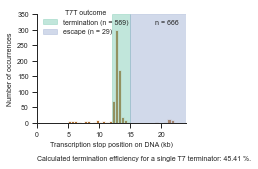

In [14]:
protein = 'T7'
#T7 Termination efficiency - visualized
fig,axes = plt.subplots()

#generate _temp_df for counting
_temp_df = pd.melt(df[df['number_ORC']==0].filter(regex=("T7_"),axis=1).xs('stop_site',level='properties',axis=1)/1000)

# plot full distribution
sns.distplot(df[df['number_ORC']==0].filter(regex=("T7_"),axis=1).xs('stop_site',level='properties',axis=1)/1000,ax=axes,
             color=sns.desaturate(palettes[protein][1],0.75),bins = np.linspace(0, 25, 51),kde=False,hist_kws={"alpha": 1})

axes.set_xlim(0,24)
axes.set_ylim(0,350)
axes.set_xlabel('Transcription stop position on DNA (kb)')
axes.set_ylabel('Number of occurrences')

axes.text(0.95, 0.95, f"n = {int(df[df['number_ORC']==0]['number_T7'].sum())}",
        verticalalignment='top', horizontalalignment='right',
        transform=axes.transAxes)

# nobs with successful termination
n_termination = ((_temp_df['value'] >= 12) & (_temp_df['value'] <= 15)).sum()
# nobs with terminator escape
n_escape = (_temp_df['value'] > 15).sum()
# calculate actual escape and term probability for a single T7 terminator
p_escape = (n_escape/(n_termination + n_escape))**(1/5)
p_term = 1 - p_escape

axes.axvspan(12, 15, alpha=0.4, color=palettes['qualitative'][0],
             label=f"termination (n = {n_termination})")
axes.axvspan(15, 24, alpha=0.4, color=palettes['qualitative'][2],
             label=f"escape (n = {n_escape})")

axes.text(0, -0.3, f"Calculated termination efficiency for a single T7 terminator: {round(p_term*100,2)} %.",
        verticalalignment='top', horizontalalignment='left',
        transform=axes.transAxes)

plt.legend(frameon=False,title='T7T outcome', bbox_to_anchor=(0,1.1),loc='upper left')
sns.despine()
#plt.tight_layout()

plt.savefig(dir_out+'S6B_Termination_efficiency_5xT7T.svg',transparent=True)

del(_temp_df)